# Momentum MA Crossover Strategy

A momentum moving average crossover strategy is a systematic trading approach where:
A short-term momentum measure (fast signal) is compared against a long-term momentum measure (slow signal) and uses short-term and long-term moving averages to identify bullish or bearish trends.
- When the fast signal rises above the slow one → bullish trend → go long.
- When the fast signal falls below the slow one → bearish trend → go short or reduce exposure.
This captures medium-term trends and filters noise, and can outperforming buy-and-hold in volatile markets like cryptocurrencies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from time import time
from typing import Optional
from itertools import combinations

## Data Loading and Preparation

We first load price data OHLCV and clean it.

In [2]:
df = pd.read_pickle('../data/binance_1D_crypto_data.pkl')
df = df[df['open_time'].dt.date != df['open_time'].dt.date.max()]
df = df.drop_duplicates(keep='first')
df.head()

,open_time,open,high,low,close,volume,symbol
0,2024-06-17,0.09500000,0.29500000,0.09500000,0.21300000,1558854668.40000000,ZKUSDT
1,2024-06-18,0.21300000,0.23200000,0.18600000,0.22020000,1189119720.30000000,ZKUSDT
2,2024-06-19,0.22020000,0.24000000,0.21260000,0.22420000,727374424.10000000,ZKUSDT
3,2024-06-20,0.22420000,0.22420000,0.19100000,0.19830000,493478200.90000000,ZKUSDT
4,2024-06-21,0.19830000,0.20360000,0.17600000,0.18220000,382766488.90000000,ZKUSDT


Closing prices are used because they reflect the final consensus of value for each trading day.
All assets/columns that have more than 10% null values are removed

In [3]:
def pivot_reindexed_data(df, value):
    new_df = df.pivot(values = value, columns = 'symbol', index = 'open_time')
    new_df = pd.DataFrame(new_df).astype(float)
    new_df = new_df.reindex(pd.date_range(new_df.index[0],new_df.index[-1],freq='1d'))
    return new_df

px = pivot_reindexed_data(df,'close').loc[:'2025-08']
# Omitting tickers with less than 90% of non null values.
px = px.loc[:,(px.notna().sum()/(px.shape[0]))>= 0.9]

vols = pivot_reindexed_data(df,'volume').loc[:'2025-08']
vols = vols[px.columns]

# Define date ranges
insample_start = pd.Timestamp("2021-06-01")
insample_end = pd.Timestamp("2023-12-31")

# val_start = pd.Timestamp("2024-01-01")
# val_end = pd.Timestamp("2024-10-31")

outsample_start = pd.Timestamp("2024-01-01")

# Training set
px_train = px.loc[:insample_end]
vols_train = px.loc[:insample_end]

In [4]:
px_train.head()

symbol,1INCHUSDT,AAVEUSDT,ADAUSDT,ALGOUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,TUSDUSDT,TWTUSDT,UNIUSDT,USDCUSDT,VETUSDT,XLMUSDT,XRPUSDT,XTZUSDT,ZECUSDT
2021-01-01,1.1550,90.711,0.17509,0.3978,NaN,5.861,3.6497,0.59310,341.83,37.7762,...,0.02685,0.9974,NaN,4.7353,0.9974,0.019052,0.13207,0.23746,2.0075,56.60
2021-01-02,1.0250,85.768,0.17742,0.4075,NaN,5.420,3.4956,0.54275,354.55,38.2331,...,0.02721,0.9989,NaN,4.8564,0.9989,0.019993,0.12751,0.22064,1.9992,57.46
2021-01-03,1.1080,93.778,0.20615,0.4253,NaN,5.829,3.4691,0.56523,423.61,41.2575,...,0.02949,0.9986,NaN,5.5155,0.9992,0.026226,0.13653,0.22540,2.1345,59.35
2021-01-04,1.0317,114.271,0.22528,0.4463,NaN,6.044,3.5999,0.56082,405.49,41.1333,...,0.03095,0.9994,NaN,5.4238,0.9994,0.024598,0.16404,0.23565,2.3284,60.34
2021-01-05,1.2501,119.689,0.25873,0.4794,NaN,6.196,4.2501,0.55605,418.09,41.8219,...,0.02852,0.9970,NaN,6.2518,0.9969,0.027964,0.19291,0.22573,2.3770,59.64


In [5]:
def drawdown(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    return drawdown

In [6]:
def duration(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    if isinstance(returns, pd.DataFrame):
        ddd = pd.DataFrame(index = returns.index, columns = returns.columns)
        for col in returns.columns:
            ddd[col] = duration[col].groupby((duration[col] != duration[col].shift()).cumsum()).cumsum()
    else:
        ddd = duration.groupby((duration != duration.shift()).cumsum()).cumsum()
    return ddd

In [7]:
def calculate_metrics(returns, benchmark:Optional = False):
    """
    Compute total return, annualized return/vol, Sharpe, max drawdown, win rate.
    """
    
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    max_duration = duration.groupby((duration != duration.shift()).cumsum()).cumsum().max()

    cum_ret = cumulative.iloc[-1] - 1
    ann_vol = returns.std() * np.sqrt(365)
    ann_ret = returns.mean() * 365
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    max_dd = drawdown.min()

    # consider only non-zero returns as individual trades
    trade_rets = returns[returns != 0]
    win_rate   = (trade_rets > 0).sum() / len(trade_rets)
    
    
    metrics = pd.Series({
        "Cumulative Return": f"{(cum_ret * 100):.2f}%",
        "Annualized Return": f"{(ann_ret * 100):.2f}%",
        "Annualized Volatility": f"{(ann_vol * 100):.2f}%",
        "Sharpe Ratio": sharpe,
        "Max Drawdown": f"{(max_dd * 100):.2f}%",
        "Max Drawdown Duration": f"{(max_duration):.2f} days",
        "Win Rate": f"{(win_rate * 100):.2f}%"
    })
    
    if benchmark:
        bench_rets = px['BTCUSDT'].ffill().pct_change().loc[returns.index]
        X = sm.add_constant(bench_rets)
        y = returns
        model = sm.OLS(y, X).fit()
        alpha = model.params['const']
        beta  = model.params['BTCUSDT']
        active_rets = returns - beta * bench_rets
        IR = active_rets.mean() / active_rets.std() * np.sqrt(365)
    
        metrics["Info Ratio"] = IR
        
    else: metrics["Info Ratio"] = "N/A"

    return metrics

In [8]:
def backtest_with_costs(prices, port, tcost_bps = 20):
    ret = prices.ffill().pct_change()
    gross_ret = (port.shift() * ret).sum(axis=1)

    # Turnover
    turnover = (port.fillna(0) - port.shift().fillna(0)).abs().sum(axis=1)

    # Cost in return units
    cost = turnover * (tcost_bps * 1e-4)
    net_ret = gross_ret - cost

    return net_ret, gross_ret, turnover

## Trading Strategy
We first compute daily percentage returns:
$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}} 
$$  
where $(P_t)$ is the price at time $(t)$.

---
#### Short-Term and Long-Term Momentum
We compute rolling averages of returns over short and long horizons:
$$
MA^{\text{short}}_t = \frac{1}{s} \sum_{i=0}^{s-1} r_{t-i}, \quad
MA^{\text{long}}_t = \frac{1}{l} \sum_{i=0}^{l-1} r_{t-i}
$$
where ${s}$ = short window, and ${l}$ = long window.

---
#### Raw Signal (Momentum Ratio)
The raw trading signal is the relative difference between short-term and long-term momentum:
$$
\text{Signal}_t = \frac{MA^{\text{short}}_t}{MA^{\text{long}}_t} - 1
$$
- Positive signal → bullish trend go long.  
- Negative signal → bearish trend go short.  

---
#### Volatility Adjustment
To avoid oversized signals in volatile markets, we normalize by rolling volatility (63-day standard deviation):
$$
\text{Signal}_t = \frac{\text{Signal}_t}{\sigma_{63}(r_t)}
$$
This makes signals comparable across different volatility regimes.

---
#### Nonlinear Transformation
We squash the signal into the range \((-1, 1)\) using the hyperbolic tangent:
$$
\text{Signal}_t = \tanh(\text{Signal}_t)
$$
This prevents extreme outliers from dominating.

---
#### Gap Adjustment (Mean Reversion Check)
We also measure the **gap** between short- and long-term moving averages of **prices**:
$$
\text{Gap}_t = \text{Price}^{\text{short}}_t - \text{Price}^{\text{long}}_t
$$
- If the gap is **decreased when we are in long position**, signals are reversed(go short) to avoid holding a losing trade too long.  
- If the gap is **decreased when we are in short position**, signals are reversed(go long) to ride the upward trend
This ensures we don’t enter late when the move is already reversed.

---
#### Portfolio Construction
We normalize signals across assets so that total exposure is 1 (fully invested portfolio):
$$
w_{i,t} = \frac{\text{Signal}_{i,t}}{\sum_j |\text{Signal}_{j,t}|}
$$

---
#### Backtesting with Costs
Finally, we compute strategy performance with transaction costs:
- **Net Returns** = returns after subtracting trading costs.  
- The **execute_strategy** function returns evaluation metrics for the strategy

In [9]:
def execute_strategy(prices, short_window, long_window, vol_scale, start = insample_start):
    ret = prices.ffill().pct_change()
    
    short_ma = ret.rolling(short_window, min_periods=short_window).mean()
    long_ma  = ret.rolling(long_window, min_periods=short_window).mean()
    
    signal = short_ma/long_ma - 1
    
    signal = signal / ret.rolling(63, min_periods=30).std()
    
    signal = np.tanh(signal)

    gap = prices.rolling(short_window, min_periods=short_window).mean() \
            - prices.rolling(long_window, min_periods=short_window).mean()
    
    # widest gap when short_ma > long_ma
    gap_max = gap.rolling(5, min_periods = 2).max()
    shrink_on_max = (1 - gap / gap_max).where(gap > 0)
    
    # widest gap when short_ma < long_ma
    gap_min = gap.rolling(2, min_periods = 2).min()
    shrink_on_min = (gap_min / gap - 1).where(gap < 0)
    
    sigma = ret.rolling(15).std()
    signal[ shrink_on_max > (sigma * vol_scale[0])] = -1 * signal.abs()
    signal[ shrink_on_min > (sigma * vol_scale[1])] = 1 * signal.abs()
    
    signal = signal * np.sqrt(ret.rolling(180, min_periods = 30).std())

    port = signal.divide(signal.abs().sum(1),0).fillna(0.0)

    net_ret, gross_ret, turnover = backtest_with_costs(prices[start:], port[start:])
    
    return calculate_metrics(net_ret, benchmark = True)

## Strategy Training
In this step, we perform a walk forward validation over different combinations of short- and long-term moving average windows to see which parameters yield the best performance.
- Short windows are tested from **20 to 35 days** (step size = 2).  
- Long windows are tested from **68 to 90 days** (step size = 2).  
- For each (short, long) pair, we run the strategy using `execute_strategy` and record the **Sharpe Ratio**.

We ignore cases where the short window is greater than or equal to the long window, since a valid momentum crossover strategy requires the short-term average to be faster than the long-term average


## Walk Forward Validation

In [10]:
# walk forward validation
splits = [
    ("2021-01", "2021-06", "2021-07", "2021-12"),
    ("2021-01", "2021-12", "2022-01", "2022-06"),
    ("2021-01", "2022-06", "2022-07", "2022-12"),
    ("2021-01", "2022-12", "2023-01", "2023-06"),
    ("2021-01", "2023-06", "2023-07", "2023-12"),
]

In [11]:
sma_windows = [x for x in range(20,35,2)] 
lma_windows = [x for x in range(68,90,2)]
vol_scales = list(combinations([x for x in np.arange(1,10,1)], 2))

results = []

for split_id, (tr_start, tr_end, val_start, val_end) in enumerate(splits, 1):
    begin = time()
    for scale in vol_scales:
        for sma in sma_windows:
            for lma in lma_windows:
                if (sma >= lma) or (lma < int(2.8*sma)) :  # must have sma shorter than lma
                    continue
                m = execute_strategy(px_train[:val_end], sma, lma, scale, start = val_start)
                sharpe_val = m['Info Ratio']
                results.append({
                    "split": split_id,
                    "vol_scale": scale,
                    "sma": sma,
                    "lma": lma,
                    "val_sharpe": sharpe_val
                })
    end = time()
    print(split_id," ",end-begin, " seconds")
    
cv_results = pd.DataFrame(results)

# Average validation performance
avg_scores = cv_results.groupby(["vol_scale", "sma", "lma"])["val_sharpe"].mean().reset_index()
best_params = avg_scores.loc[avg_scores["val_sharpe"].idxmax()]

print("Average validation scores (top 5):")
print(avg_scores.sort_values("val_sharpe", ascending=False).head())
print("\nBest parameter pair:", dict(best_params))

1   41.150184869766235  seconds
2   45.83503317832947  seconds
3   49.84747791290283  seconds
4   53.09782671928406  seconds
5   56.325632095336914  seconds
Average validation scores (top 5):
    vol_scale  sma  lma  val_sharpe
12     (1, 2)   22   70    0.914759
420    (2, 3)   22   70    0.890627
63     (1, 3)   22   70    0.885200
14     (1, 2)   22   74    0.858310
779    (3, 4)   22   74    0.837036

Best parameter pair: {'vol_scale': (1, 2), 'sma': 22, 'lma': 70, 'val_sharpe': 0.9147594870051667}


In [12]:
print("Parameters with non negative scores across all validation sets: ")
a_filter =(cv_results.groupby(["vol_scale", "sma", "lma"])["val_sharpe"].min() > 0).reset_index()
print(avg_scores[a_filter.val_sharpe].sort_values("val_sharpe", ascending=False))

Parameters with non negative scores across all validation sets: 
   vol_scale  sma  lma  val_sharpe
43    (1, 2)   28   80    0.756129


That shows it's the only parameter set that was not overfit, it tried to create returns across all validation windows

In [13]:
print(cv_results[(cv_results.sma == 28) & (cv_results.lma == 80) & 
                 (cv_results.vol_scale == (1,2))].set_index('split'),'\n')

      vol_scale  sma  lma  val_sharpe
split                                
1        (1, 2)   28   80    0.786189
2        (1, 2)   28   80    0.884166
3        (1, 2)   28   80    0.048624
4        (1, 2)   28   80    1.432124
5        (1, 2)   28   80    0.629542 



## Strategy Execution Insample/Training Set

The average turnover is 0.2662084854034048
The holding period is 7.5129085271991105 days
                      strat_gross_ret strat_net_ret     btc_hodl
Cumulative Return             239.24%       105.33%       13.50%
Annualized Return              55.18%        35.75%       22.30%
Annualized Volatility          39.69%        39.68%       58.92%
Sharpe Ratio                 1.390366      0.900898     0.378523
Max Drawdown                  -29.78%       -31.15%      -76.63%
Max Drawdown Duration     166.00 days   308.00 days  783.00 days
Win Rate                       53.66%        51.69%       48.62%
Info Ratio                        N/A      0.890109          N/A


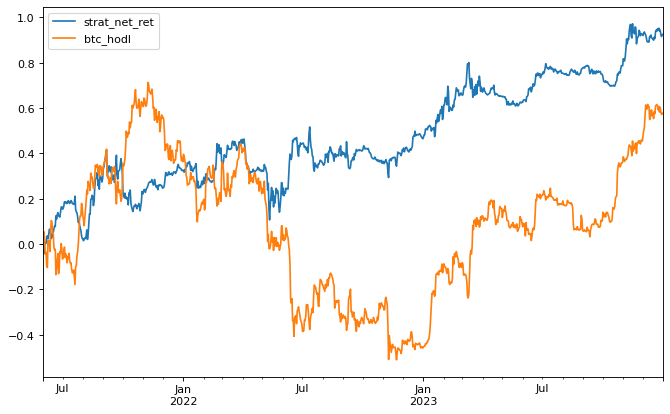

In [14]:
short_window = 28
long_window =  80

prices = px_train

ret = prices.ffill().pct_change()

short_ma = ret.rolling(short_window, min_periods=short_window).mean()
long_ma  = ret.rolling(long_window, min_periods=short_window).mean()

signal = short_ma/long_ma - 1

# normalizing the signal by rolling volatility
signal = signal / ret.rolling(63, min_periods = 30).std() 

signal = np.tanh(signal)

gap = prices.rolling(short_window, min_periods=short_window).mean() \
        - prices.rolling(long_window, min_periods=short_window).mean()

gap_max = gap.rolling(5, min_periods = 2).max()
shrink_on_max = (1 - gap / gap_max).where(gap > 0)

gap_min = gap.rolling(2, min_periods = 2).min()
shrink_on_min = (gap_min / gap - 1).where(gap < 0)

sigma = ret.rolling(15).std()
signal[ shrink_on_max > (sigma * 1)] = -1 * signal.abs()
signal[ shrink_on_min > (sigma * 2)] = 1 * signal.abs()

signal = signal * np.sqrt(ret.rolling(180, min_periods = 30).std())

port = signal.divide(signal.abs().sum(1),0).fillna(0.0)
    
net_ret, gross_ret, turnover = backtest_with_costs(prices[insample_start:], port[insample_start:])

print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean()} days")

return_table = pd.DataFrame({
    'strat_gross_ret': calculate_metrics(gross_ret),
    'strat_net_ret': calculate_metrics(net_ret, True),
    'btc_hodl': calculate_metrics(ret.loc[insample_start:]['BTCUSDT']),
})

print(return_table)

overall = pd.DataFrame({
    'strat_net_ret': net_ret.loc[insample_start:],
    'btc_hodl': ret.loc[insample_start:]['BTCUSDT']
})

overall.cumsum().plot(figsize = (10,6));

The strategy significantly outperforms BTC buy-and-hold. Even after transaction costs, annualized return (35.75%) is above BTC’s 22.3%.  

**Better Risk-Adjusted Performance:** - The strategy’s Sharpe ratio (0.90 net) indicates strong returns per unit of risk, compared to BTC’s 0.38.  
**Lower Risk:** - Annualized volatility is lower than BTC’s, meaning the strategy is less volatile overall.  
**Shallower Drawdowns:** - The worst loss from peak to trough was ~31.15% for the strategy, much smaller than BTC’s -76.6%. Recovery time was also shorter (308 days vs. 783 days).  
**Higher Win Rate:** - The strategy wins slightly more than half of trades 51.69%, while BTC only wins 48.6%.  

✅ **Overall:** The momentum crossover strategy delivers **higher returns with lower risk and shorter drawdowns** compared to a passive BTC buy-and-hold approach.

In [15]:
consistency_table = pd.DataFrame({
    'strat_ret_2021': calculate_metrics(net_ret.loc['2021']),
    'strat_ret_2022': calculate_metrics(net_ret.loc['2022']),
    'strat_ret_2023': calculate_metrics(net_ret.loc['2023'])
})

btc_table = pd.DataFrame({
    'btc_hodl_2021': calculate_metrics(ret['BTCUSDT'].loc[insample_start:'2021-12-31']),
    'btc_hodl_2022': calculate_metrics(ret['BTCUSDT'].loc['2022']),
    'btc_hodl_2023': calculate_metrics(ret['BTCUSDT'].loc['2023'])
})

print('Strategy Yearly Performance:')
print(consistency_table.to_string(), '\n')

print('----------------------------------------------')
print('BTC Buy and Hold Yearly Performance:')
print(btc_table.to_string())

Strategy Yearly Performance:
                      strat_ret_2021 strat_ret_2022 strat_ret_2023
Cumulative Return             30.42%          5.08%         49.83%
Annualized Return             55.08%         14.12%         46.05%
Annualized Volatility         43.97%         42.76%         33.43%
Sharpe Ratio                1.252702       0.330171       1.377534
Max Drawdown                 -25.71%        -31.06%        -18.75%
Max Drawdown Duration    116.00 days    172.00 days    237.00 days
Win Rate                      54.21%         49.59%         52.33%
Info Ratio                       N/A            N/A            N/A 

----------------------------------------------
BTC Buy and Hold Yearly Performance:
                      btc_hodl_2021 btc_hodl_2022 btc_hodl_2023
Cumulative Return            24.06%       -64.21%       155.61%
Annualized Return            61.86%       -82.09%       103.51%
Annualized Volatility        70.88%        63.74%        44.06%
Sharpe Ratio              

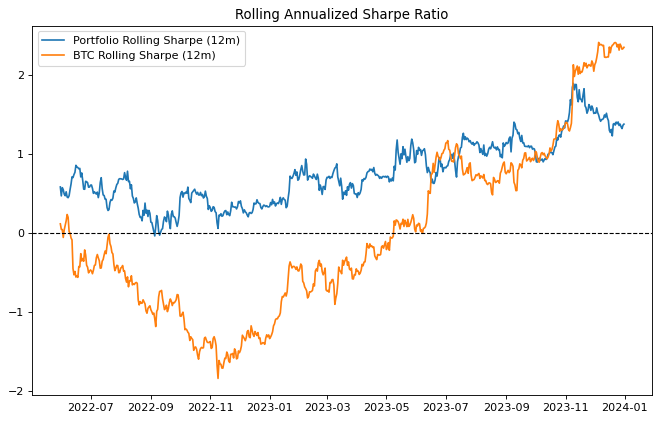

In [16]:
def annualized_sharpe(rets, periods_per_year=365):
    """Compute annualized Sharpe ratio from daily returns."""
    return np.sqrt(periods_per_year) * rets.mean() / rets.std()

# rolling Sharpe (12-month window)
rolling = net_ret.rolling(window=365).apply(
    lambda x: annualized_sharpe(x), raw=False)
rolling_btc = ret.loc[insample_start:]['BTCUSDT'].rolling(window=365).apply(
    lambda x: annualized_sharpe(x), raw=False)


plt.figure(figsize=(10, 6))
plt.plot(rolling.index, rolling, label='Portfolio Rolling Sharpe (12m)')
plt.plot(rolling_btc.index, rolling_btc, label='BTC Rolling Sharpe (12m)')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.title('Rolling Annualized Sharpe Ratio')
plt.show()

## Strategy Execution Test Set

The average turnover is 0.25425974986362004
The holding period is 7.865971712285412 days
                      strat_gross_ret strat_net_ret     btc_hodl
Cumulative Return             285.31%       182.79%      156.00%
Annualized Return              91.78%        73.21%       68.47%
Annualized Volatility          46.62%        46.65%       49.41%
Sharpe Ratio                 1.968457      1.569557     1.385727
Max Drawdown                  -35.32%       -36.00%      -28.10%
Max Drawdown Duration     110.00 days   113.00 days  237.00 days
Win Rate                       54.44%        52.71%       51.72%
Info Ratio                   2.126108      1.726018          N/A


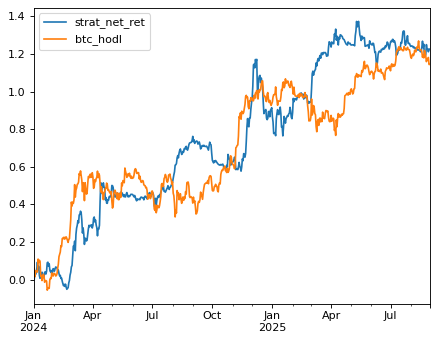

In [17]:
short_window = 28
long_window =  80 

prices = px

ret = prices.ffill().pct_change()

short_ma = ret.rolling(short_window, min_periods=short_window).mean()
long_ma  = ret.rolling(long_window, min_periods=short_window).mean()

signal = short_ma/long_ma - 1

# normalizing the signal by rolling volatility
signal = signal / ret.rolling(63, min_periods = 30).std()

signal = np.tanh(signal)

gap = prices.rolling(short_window, min_periods=short_window).mean() \
        - prices.rolling(long_window, min_periods=short_window).mean()

gap_max = gap.rolling(5, min_periods = 2).max()
shrink_on_max = (1 - gap / gap_max).where(gap > 0)

gap_min = gap.rolling(2, min_periods = 2).min()
shrink_on_min = (gap_min / gap - 1).where(gap < 0)

sigma = ret.rolling(15).std()
signal[ shrink_on_max > (sigma * 1)] = -1 * signal.abs()
signal[ shrink_on_min > (sigma * 2)] = 1 * signal.abs()

signal = signal * np.sqrt(ret.rolling(180, min_periods = 30).std())

port = signal.divide(signal.abs().sum(1),0)
    
net_ret, gross_ret, turnover = backtest_with_costs(prices[outsample_start:], port[outsample_start:])

print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean()} days")

return_table = pd.DataFrame({
    'strat_gross_ret': calculate_metrics(gross_ret, True),
    'strat_net_ret': calculate_metrics(net_ret, True),
    'btc_hodl': calculate_metrics(ret.loc[outsample_start:]['BTCUSDT']),
})

print(return_table)

overall = pd.DataFrame({
    'strat_net_ret': net_ret,
    'btc_hodl': ret.loc[outsample_start:]['BTCUSDT']
})

overall.cumsum().plot();

## Holdout Sample Strategy Performance vs. BTC Buy-and-Hold

**Higher Annualized Return:** - Net annualized return is **73.2%**, compared to BTC’s 68.5%.
**Better Risk-Adjusted Returns:** - The strategy’s net Sharpe ratio (**1.57**) is nearly double BTC’s (**1.39**).  
**Lower Volatility:** - Strategy volatility (46.7%) is significantly lower than BTC’s (49.4%).  
**Faster Recovery:** - Strategy drawdown duration (113 days) is shorter than BTC’s (237 days). 
**Consistent Edge:** - Strategy’s win rate (52.7%) remains above BTC’s (51.7%).  

✅ **Overall:** Over the full sample, the momentum crossover strategy consistently outperforms BTC buy-and-hold with **higher returns, lower volatility, smaller drawdowns, and better risk-adjusted performance**.

In [18]:
overall.cumsum().iloc[-1]

strat_net_ret    1.221584
btc_hodl         1.142456
Name: 2025-08-31 00:00:00, dtype: float64

In [19]:
# Comparing volatility-scaled returns to the benchmark
target_vol = ret['BTCUSDT'].loc[outsample_start:].std() * np.sqrt(365)
strat_vol = net_ret.std() * np.sqrt(365)
scaled_ret = net_ret * target_vol / strat_vol

scaled_ret_table = pd.DataFrame({
    'strat_net_ret': calculate_metrics(scaled_ret),
    'btc_hodl': calculate_metrics(ret['BTCUSDT'].loc[outsample_start:]),
})

print(scaled_ret_table)

                      strat_net_ret     btc_hodl
Cumulative Return           197.35%      156.00%
Annualized Return            77.56%       68.47%
Annualized Volatility        49.41%       49.41%
Sharpe Ratio               1.569557     1.385727
Max Drawdown                -37.83%      -28.10%
Max Drawdown Duration   113.00 days  237.00 days
Win Rate                     52.71%       51.72%
Info Ratio                      N/A          N/A


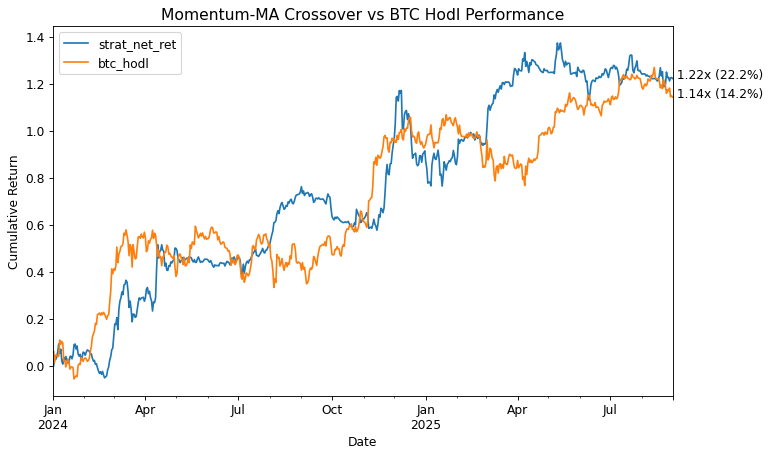

In [20]:
ax = overall.cumsum().plot(title = 'Momentum-MA Crossover vs BTC Hodl Performance',figsize = (10,6));

ax.set_title("Momentum-MA Crossover vs BTC Hodl Performance", fontsize=14)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,0], s=' 1.22x (22.2%)', 
        color="black", fontsize=11)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,1], s=' 1.14x (14.2%)', 
        color="black", fontsize=11)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Cumulative Return', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

In [21]:
consistency_table = pd.DataFrame({
    'strat_ret_2024': calculate_metrics(net_ret.loc['2024']),
    'strat_ret_2025': calculate_metrics(net_ret.loc['2025']),
})

btc_table = pd.DataFrame({
    'btc_hodl_2024': calculate_metrics(ret['BTCUSDT'].loc['2024']),
    'btc_hodl_2025': calculate_metrics(ret['BTCUSDT'].loc['2025']),
})

print('Strategy Yearly Performance:')
print(consistency_table.to_string(), '\n')

print('----------------------------------------------')
print('BTC Buy and Hold Yearly Performance:')
print(btc_table.to_string())

Strategy Yearly Performance:
                      strat_ret_2024 strat_ret_2025
Cumulative Return            121.64%         27.59%
Annualized Return             91.15%         46.21%
Annualized Volatility         48.37%         43.98%
Sharpe Ratio                1.884298         1.0506
Max Drawdown                 -29.17%        -22.07%
Max Drawdown Duration    110.00 days    113.00 days
Win Rate                      55.19%         48.97%
Info Ratio                       N/A            N/A 

----------------------------------------------
BTC Buy and Hold Yearly Performance:
                      btc_hodl_2024 btc_hodl_2025
Cumulative Return           121.31%        15.68%
Annualized Return            93.22%        31.20%
Annualized Volatility        53.08%        43.35%
Sharpe Ratio               1.756296      0.719779
Max Drawdown                -26.15%       -28.10%
Max Drawdown Duration   237.00 days   116.00 days
Win Rate                     52.46%        50.62%
Info Ratio       

The strategy performance is consistent over the years maintaing a sharpe greater than 1

In [22]:
btc_hodl_ret = ret.loc[outsample_start:]['BTCUSDT']

In [23]:
net_ret.name = 'strat_net_ret'
btc_hodl_ret.name = 'btc_hodl'
df_rets = pd.concat([net_ret, btc_hodl_ret], axis = 1)

strat_net_ret   -0.359999
btc_hodl        -0.280953
dtype: float64


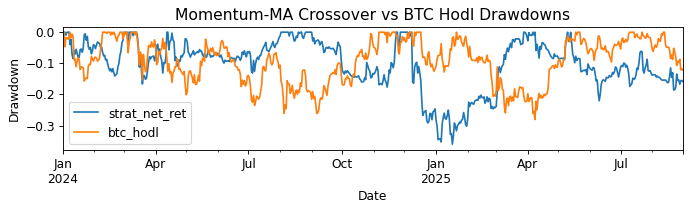

In [24]:
print(drawdown(df_rets).min())
s = drawdown(df_rets)
ax = s.plot( figsize = (10,2), title = "Momentum-MA Crossover vs BTC Hodl Drawdowns", 
            xlabel = "Date", ylabel = "Drawdown");

ax.set_title("Momentum-MA Crossover vs BTC Hodl Drawdowns", fontsize=14)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Drawdown', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

maximum drawdown -36%, the strategy maintained shallower drawdowns and faster recovery throughout the years

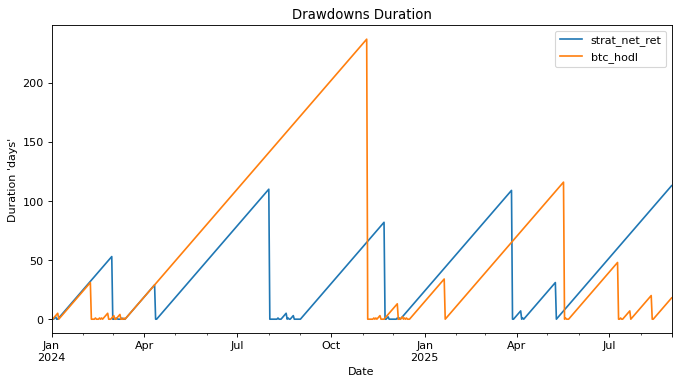

In [25]:
duration(df_rets).plot( figsize = (10,5), title = "Drawdowns Duration", 
                       xlabel = "Date", ylabel = "Duration 'days'");

In [26]:
data = pd.concat([net_ret, btc_hodl_ret], axis=1).dropna()
y = data.iloc[:,0]   # strategy
x = data.iloc[:,1]   # benchmark

#Regression (to get alpha & beta)
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
alpha_daily, beta = model.params
alpha_ann = alpha_daily * 365  # annualized alpha

# Residual Returns
resid_ret = y - beta * x
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          strat_net_ret   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     6.885
Date:                Tue, 23 Sep 2025   Prob (F-statistic):            0.00891
Time:                        10:18:00   Log-Likelihood:                 1400.7
No. Observations:                 609   AIC:                            -2797.
Df Residuals:                     607   BIC:                            -2789.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      2.222      0.0

In [27]:
print("Alpha (annualized):", alpha_ann)
print("Beta:", beta)

Alpha (annualized): 0.8006041796204061
Beta: -0.09997671081029642


- **Alpha (80.1% annualized)**: The strategy consistently generates excess returns independent of market movements.  
- **Beta (-0.1)**: The strategy is effectively market-neutral with a tiny tilt against BTC — it doesn’t depend on BTC rallies to make money, and sometimes even benefits a little when BTC drops.

In [28]:
SR = net_ret.mean() / net_ret.std() * np.sqrt(365)
IR = resid_ret.mean() / resid_ret.std() * np.sqrt(365)

print('Strategy Sharpe Ratio is ', SR)
print('Strategy Information Ratio is ', IR)

Strategy Sharpe Ratio is  1.5695565670541103
Strategy Information Ratio is  1.7260179406866778


Strategy information ratio is 1.73 which shows consistent and risk efficiency over the benchmark.

At **1.73 IR**, this strategy provides a reliable edge over BTC buy-and-hold

In [29]:
vol = {}
vol['original volatility'] = net_ret.std()*np.sqrt(365)
vol['residual volatility'] = resid_ret.std()*np.sqrt(365)
vol

{'original volatility': 0.4664679206103764,
 'residual volatility': 0.46384464538178194}

In [30]:
print('Strategy return correlation with btc hodl return is ', net_ret.corr(btc_hodl_ret))
print('Strategy residual return correlation with btc hodl return is ', resid_ret.corr(btc_hodl_ret))

Strategy return correlation with btc hodl return is  -0.10590454297343087
Strategy residual return correlation with btc hodl return is  -1.9083531925836683e-16
